# GUT of Imaging Results


In [ ]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from labellines import labelLines

(32940,)
(3000,)
(3000,)


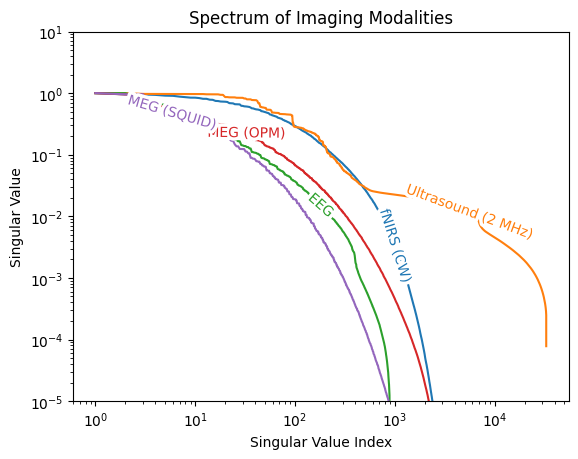

In [69]:
from guti.data_utils import load_all_svds

# Load all SVD spectrums
all_svds = load_all_svds()

filenames_to_labels = {
    "eeg_openmeeg": "EEG",
    "fnirs_analytical_cw": "fNIRS (CW)",
    "us_analytical": "Ultrasound (2 MHz)",
    "meg_opm": "MEG (OPM)",
    "meg_squid": "MEG (SQUID)",
}

# Plot all spectrums
ax = plt.gca()
for modality_name, (s, params) in all_svds.items():
    ax.plot(
        np.arange(1, len(s) + 1),
        s / s[0],
        label=filenames_to_labels.get(modality_name, modality_name),
    )

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Singular Value Index")
ax.set_ylabel("Singular Value")
ax.set_title("Spectrum of Imaging Modalities")
ax.set_ylim(1e-5, 10)

# Use labellines instead of legend
labelLines(ax.get_lines(), zorder=2.5)

plt.savefig("spectrum.png")
plt.show()

In [70]:
from guti.core import get_bitrate_channel_capacity

snr_per_modalities = {
    "eeg_openmeeg": 100.0,
    "fnirs_analytical_cw": 100.0,
    "meg_opm": 10.0,
    "meg_squid": 10.0,
    "us_analytical": 1.0
}

time_resolution_per_modality = {
    "eeg_openmeeg": 10e-3,
    "fnirs_analytical_cw": 1.0,
    "meg_opm": 10e-3,
    "meg_squid": 10e-3,
    "us_analytical": 1.0,
}

channel_capacities = {}

# Plot all spectrums
for modality_name, (s, params) in all_svds.items():
    channel_capacity = get_bitrate_channel_capacity(s.astype(np.float64),
        snr_at_reference_nsensors=snr_per_modalities[modality_name],
        time_resolution=time_resolution_per_modality[modality_name]
    )
    if modality_name == "us_analytical":
        channel_capacity *= (2000/40)**3 # for 1 MHZ
    channel_capacities[modality_name] = channel_capacity

    print(f"{modality_name}: {channel_capacities[modality_name]:.2f} bits/s")




fnirs_analytical_cw: 544.92 bits/s
us_analytical: 87088.24 bits/s
eeg_openmeeg: 21620.59 bits/s
meg_opm: 2265.09 bits/s
meg_squid: 1723.82 bits/s


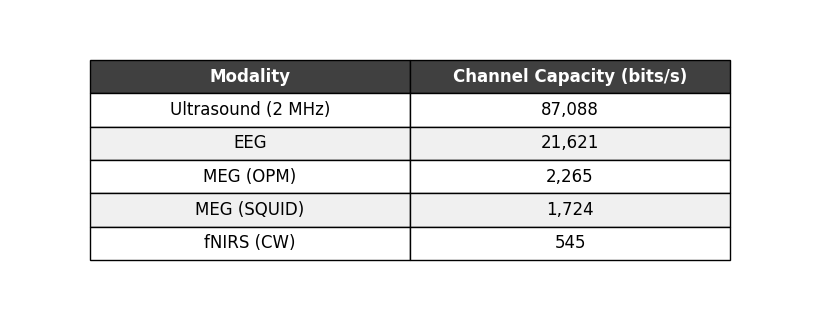

In [71]:
import matplotlib.pyplot as plt

# Prepare data for table
modalities = []
bitrates = []
for modality_name in sorted(channel_capacities.keys(), key=lambda x: channel_capacities[x], reverse=True):
    label = filenames_to_labels.get(modality_name, modality_name)
    modalities.append(label)
    bitrates.append(channel_capacities[modality_name])

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 3))
ax.axis('off')

# Remove all padding/margins around the axes
fig.subplots_adjust(left=0, right=1, top=1, bottom=0)
ax.margins(0)

# Create table data
table_data = []
for mod, br in zip(modalities, bitrates):
    formatted_br = f"{br:,.0f}"
    table_data.append([mod, formatted_br])

# Create table
table = ax.table(
    cellText=table_data,
    colLabels=['Modality', 'Channel Capacity (bits/s)'],
    cellLoc='center',
    loc='center',
    colWidths=[0.4, 0.4]
)

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 2)

# Style header row (grayscale)
for i in range(2):
    table[(0, i)].set_facecolor('#404040')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Style alternating rows
for i in range(1, len(table_data) + 1):
    for j in range(2):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#f0f0f0')
        else:
            table[(i, j)].set_facecolor('white')

# Tighten layout to table only
fig.tight_layout(pad=0)

# Force layout to compute actual bounding box
fig.canvas.draw()

# Save with no whitespace
plt.savefig(
    'bitrate.png',
    dpi=300,
    bbox_inches='tight',
    pad_inches=0,
    facecolor='white',
    edgecolor='none'
)

plt.show()